# 1. 환경 설정

## 1-1. 라이브러리

In [1]:
!pip install --upgrade tensorflow-probability

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
# 필요한 라이브러리 로드
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, \
                            precision_score, recall_score
from sklearn.preprocessing import StandardScaler, RobustScaler

import tensorflow_probability as tfp
tfd = tfp.distributions

np.random.seed(0)
tf.random.set_seed(0)

## 1-2. 데이터셋 로드

In [34]:
from google.colab import drive
drive.mount('/content/drive') # 구글 드라이브를 사용하는 경우

train_df = pd.read_csv("/content/drive/MyDrive/dacon/unsupervised_card/data/train.csv")
val_df = pd.read_csv("/content/drive/MyDrive/dacon/unsupervised_card/data/val.csv")
test_df = pd.read_csv("/content/drive/MyDrive/dacon/unsupervised_card/data/test.csv") 

print("================데이터셋 크기================")
print(train_df.shape) # 569 샘플, 32 컬럼으로 구성된 데이터
print("================데이터셋 구조================")
print(train_df.info())
print("================데이터셋 샘플================")
train_df.head() # 데이터 샘플

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
================데이터셋 크기================
(113842, 31)
================데이터셋 구조================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113842 entries, 0 to 113841
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      113842 non-null  int64  
 1   V1      113842 non-null  float64
 2   V2      113842 non-null  float64
 3   V3      113842 non-null  float64
 4   V4      113842 non-null  float64
 5   V5      113842 non-null  float64
 6   V6      113842 non-null  float64
 7   V7      113842 non-null  float64
 8   V8      113842 non-null  float64
 9   V9      113842 non-null  float64
 10  V10     113842 non-null  float64
 11  V11     113842 non-null  float64
 12  V12     113842 non-null  float64
 13  V13     113842 non-null  float64
 14  V14     113842 non-null  float64
 15  V15     113842 n

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,3,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,4,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,6,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,8,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,9,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901


In [35]:
val_df['Class'].value_counts()

0    28432
1       30
Name: Class, dtype: int64

In [36]:
fraud = (val_df['Class'] == 1).sum()
normal = (val_df['Class'] == 0).sum()

total = fraud + normal

print(f"Total = {total:,}")
print(f"Fraud = {fraud/total*100:,.2f}%")
print(f"Normal = {normal/total*100:,.2f}%")

Total = 28,462
Fraud = 0.11%
Normal = 99.89%


In [37]:
# val_df.loc[:, 'V30'] = np.log(val_df.loc[:, 'V30'] + 1)

In [38]:
# train_df = train_df.drop(columns=['V29'])
# val_df = val_df.drop(columns=['V29'])
# test_df = test_df.drop(columns=['V29'])

## 1-3. 데이터셋 지정
- val 데이터 사용 시만 실행

In [39]:
train_df = val_df.copy()
val_y = train_df['Class']

train_df = train_df.drop(columns=['Class'])

# 2. 데이터 전처리

In [40]:
val_normal, val_fraud = val_df['Class'].value_counts()
val_contamination = val_fraud / val_normal
print(f'Validation contamination : [{val_contamination}]')

Validation contamination : [0.0010551491277433877]


In [41]:
# Train dataset은 Label이 존재하지 않음
# train_x = train_df.drop(columns=['ID']) # Input Data
# Validation 사용 테스트
train_x = val_df.drop(columns=['ID']) # Input Data

In [42]:
train_x.shape

(28462, 31)

In [43]:

col = train_x.columns.drop('Class')
# col = train_x.columns

for i in col:
    sc=StandardScaler()
    train_x[i]=sc.fit_transform(train_x[i].values.reshape(-1,1))

In [44]:
X_train, X_test, y_train, y_test = train_test_split(train_x.drop(columns=['Class']).values, train_x['Class'].values, test_size=0.5, random_state=555)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14231, 30), (14231, 30), (14231,), (14231,))

In [45]:
np.bincount(y_train) / len(y_train)

array([9.99086501e-01, 9.13498700e-04])

In [46]:
np.bincount(y_test) / len(y_test)

array([0.99880542, 0.00119458])

In [47]:
X_train_normal = X_train[y_train == 0]
X_train_fraud = X_train[y_train == 1]

X_train_normal.shape, X_train_fraud.shape

((14218, 30), (13, 30))

In [48]:
X_test_normal = X_test[y_test == 0]
X_test_fraud = X_test[y_test == 1]

X_test_normal.shape, X_test_fraud.shape

((14214, 30), (17, 30))

# 3. 모델링

## 3-1. Auto Encoder

In [70]:
def encoder_model(input_dim, latent_dim):
    prior = tfd.MultivariateNormalDiag(
            loc=tf.zeros([latent_dim]),
            scale_diag=tf.ones([latent_dim]))
    
    encoder_input = Input(shape=(input_dim,))
    x = Dense(64, activation=tf.nn.leaky_relu)(encoder_input)
    x = tf.nn.dropout(x, 0.2)
    x = Dense(32, activation=tf.nn.leaky_relu)(x)
    x = tf.nn.dropout(x, 0.2)
    x = Dense(16, activation=tf.nn.leaky_relu)(x)
    x = tf.nn.dropout(x, 0.2)
    x = Dense(tfp.layers.MultivariateNormalTriL.params_size(latent_dim), activation=None)(x)
    encoded = tfp.layers.MultivariateNormalTriL(latent_dim, 
                        activity_regularizer=tfp.layers.KLDivergenceRegularizer(prior))(x)
    encoder = Model(encoder_input, encoded)
    return encoder

def decoder_model(latent_dim, input_dim):
    decoder_input = Input(shape=(latent_dim,))
    x = Dense(16, activation=tf.nn.leaky_relu)(decoder_input)
    x = tf.nn.dropout(x, 0.2)
    x = Dense(32, activation=tf.nn.leaky_relu)(x)
    x = tf.nn.dropout(x, 0.2)
    x = Dense(65, activation=tf.nn.leaky_relu)(x)
    x = tf.nn.dropout(x, 0.2)
    x = Dense(tfp.layers.IndependentNormal.params_size(input_dim), activation=None)(x)
    decoded = tfp.layers.IndependentNormal(input_dim)(x)

    decoder = Model(decoder_input, decoded)
    return decoder

def vae_model(encoder, decoder):
    vae = Model(inputs=encoder.inputs,
                outputs=decoder(encoder.outputs[0]))

    negloglik = lambda x, rv_x: -rv_x.log_prob(x)

    vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                loss=negloglik)
    return vae

In [71]:
input_dim = X_train_normal.shape[1]

latent_dim = 5
# latent_dim = 2

encoder = encoder_model(input_dim, latent_dim)
encoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_12 (Dense)            (None, 64)                1984      
                                                                 
 tf.nn.dropout_8 (TFOpLambda  (None, 64)               0         
 )                                                               
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 tf.nn.dropout_9 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 dense_14 (Dense)            (None, 16)                528 

In [72]:
decoder = decoder_model(latent_dim, input_dim)
decoder.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 5)]               0         
                                                                 
 dense_16 (Dense)            (None, 16)                96        
                                                                 
 tf.nn.dropout_11 (TFOpLambd  (None, 16)               0         
 a)                                                              
                                                                 
 dense_17 (Dense)            (None, 32)                544       
                                                                 
 tf.nn.dropout_12 (TFOpLambd  (None, 32)               0         
 a)                                                              
                                                                 
 dense_18 (Dense)            (None, 65)                2145

In [73]:
vae = vae_model(encoder, decoder)
vae.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_12 (Dense)            (None, 64)                1984      
                                                                 
 tf.nn.dropout_8 (TFOpLambda  (None, 64)               0         
 )                                                               
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 tf.nn.dropout_9 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 dense_14 (Dense)            (None, 16)                528 

## 3-2. 모델 학습

In [74]:
# 모델 저장 경로
import os
model_dir = "/content/drive/MyDrive/dacon/unsupervised_card/220728_VA/"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

# 체크포인트 파일 저장 경로
checkpoint_path = model_dir+"checkpoints_model_ae.ckpt"

In [75]:
batch_size = 16
max_epochs = 1000

s = time.time()

checkpointer = ModelCheckpoint(filepath=model_dir+"checkpoints_model_va.h5", verbose=0, save_best_only=True)

earlystopper = EarlyStopping(monitor='val_loss', mode='min', 
                             patience=10, verbose=0, restore_best_weights=True)

history = vae.fit(X_train_normal, X_train_normal, 
                  epochs=max_epochs, batch_size=batch_size, shuffle=True,
                  verbose=1, validation_data=(X_test_normal, X_test_normal),
                  callbacks=[earlystopper, checkpointer])

Epoch 1/1000
889/889 [==============================] - 15s 12ms/step - loss: 44.3330 - val_loss: 41.2673
Epoch 2/1000
889/889 [==============================] - 8s 9ms/step - loss: 40.3132 - val_loss: 39.4273
Epoch 3/1000
889/889 [==============================] - 10s 12ms/step - loss: 39.9861 - val_loss: 38.9731
Epoch 4/1000
889/889 [==============================] - 8s 9ms/step - loss: 39.3164 - val_loss: 38.7859
Epoch 5/1000
889/889 [==============================] - 10s 12ms/step - loss: 38.3174 - val_loss: 38.0247
Epoch 6/1000
889/889 [==============================] - 8s 9ms/step - loss: 37.8633 - val_loss: 37.6565
Epoch 7/1000
889/889 [==============================] - 10s 12ms/step - loss: 37.7012 - val_loss: 37.3908
Epoch 8/1000
889/889 [==============================] - 10s 11ms/step - loss: 37.1009 - val_loss: 36.9576
Epoch 9/1000
889/889 [==============================] - 10s 12ms/step - loss: 37.0899 - val_loss: 36.8057
Epoch 10/1000
889/889 [=============================

In [76]:
print(f"경과 시간: {(time.time() - s) / 60} 분")

경과 시간: 13.302271473407746 분


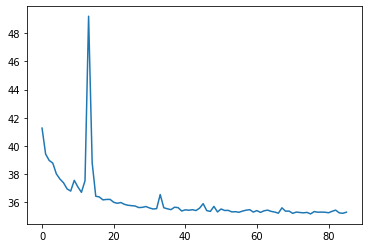

In [77]:
plt.plot([v for v in history.history['val_loss'] if v < 50])

In [78]:
vae.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_12 (Dense)            (None, 64)                1984      
                                                                 
 tf.nn.dropout_8 (TFOpLambda  (None, 64)               0         
 )                                                               
                                                                 
 dense_13 (Dense)            (None, 32)                2080      
                                                                 
 tf.nn.dropout_9 (TFOpLambda  (None, 32)               0         
 )                                                               
                                                                 
 dense_14 (Dense)            (None, 16)                528 

# 4. 성능평가

In [79]:
# 정상 sample 무작위 sampling 
idx = np.random.choice(len(X_train_normal), 250, replace=False)
Nom_data = X_train_normal[idx]
Nom_data.shape 

(250, 30)

In [80]:
# 정상 데이터의 재구성 결과 값
Nom_pred = vae.predict(Nom_data)  
# 재구성 오류 -  input/output 간의 MSE 구하기
Nom_pred_mse = np.mean(np.power(Nom_data - Nom_pred, 2), axis=1) 

print('Normal Metric')
Nom_pred_mse_df = pd.DataFrame({'Normal_mse': Nom_pred_mse})
print(Nom_pred_mse_df.describe())

8/8 [==============================] - 2s 3ms/step
Normal Metric
       Normal_mse
count  250.000000
mean     2.243572
std      6.538653
min      0.303092
25%      0.927695
50%      1.279592
75%      1.849252
max     97.932582


In [81]:
# 비정상 data의 재구성 결과값
ANom_pred = vae.predict(X_train_fraud)   
# 재구성 오류 -  input/output 간의 MSE 구하기
ANom_pred_mse = np.mean(np.power(X_train_fraud - ANom_pred, 2), axis=1) 

print('Anomaly Metric')
ANom_pred_mse_df = pd.DataFrame({'Anomaly_mse':ANom_pred_mse})
print(ANom_pred_mse_df.describe())

1/1 [==============================] - 0s 18ms/step
Anomaly Metric
       Anomaly_mse
count    13.000000
mean     38.361230
std      53.843382
min       0.919093
25%       2.532042
50%       8.585950
75%      66.424868
max     173.473458


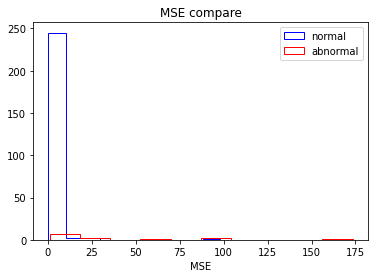

In [82]:
plt.title('MSE compare') 
plt.hist(Nom_pred_mse, bins=10, color='blue', histtype='step', label='normal') 
plt.hist(ANom_pred_mse, bins=10, color='red', histtype='step', label='abnormal') 
plt.xlabel('MSE')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


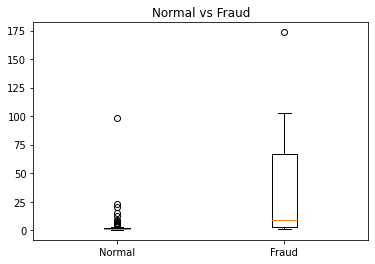

In [83]:
plt.boxplot([Nom_pred_mse, ANom_pred_mse])
plt.title('Normal vs Fraud')
plt.xticks(ticks=[1, 2], labels=['Normal', 'Fraud'])
plt.show()

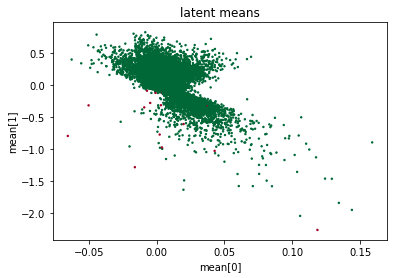

In [84]:
# X_test의 잠재 표현 평균 계산
latent_x_mean = encoder(X_test).mean()

plt.scatter(latent_x_mean[:, 0], latent_x_mean[:, 1], c=y_test, cmap='RdYlGn_r', s=2)
plt.title('latent means')
plt.ylabel('mean[1]')
plt.xlabel('mean[0]')
plt.show()

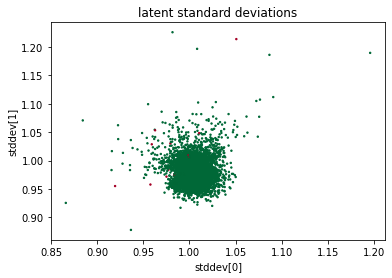

In [85]:
# X_test의 잠재 표현 표준 편차 계산
latent_x_std = encoder(X_test).stddev()
plt.scatter(latent_x_std[:, 0], latent_x_std[:, 1], c=y_test, cmap='RdYlGn_r', s=2)
plt.title('latent standard deviations')
plt.ylabel('stddev[1]')
plt.xlabel('stddev[0]')
plt.show()

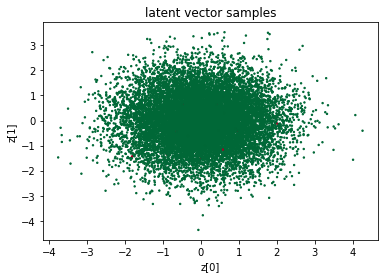

In [86]:
# X_test의 잠재 표현 시각화
latent_x = encoder(X_test).sample()
plt.scatter(latent_x[:, 0], latent_x[:, 1], c=y_test, cmap='RdYlGn_r', s=2)
plt.title('latent vector samples')
plt.ylabel('z[1]')
plt.xlabel('z[0]')
plt.show()

In [87]:
# train set의 재구성 오류 계산 (0 - 정상, 1 - 사기)
predictions = vae.predict(X_train)

mse = np.mean(np.power(X_train - predictions, 2), axis=1)

error_df = pd.DataFrame({'reconstruction_error': mse, 'true_class': y_train})

445/445 [==============================] - 1s 3ms/step


In [88]:
desc = error_df.groupby('true_class').describe()
desc

reconstruction_error                                            \
                          count       mean        std       min       25%   
true_class                                                                  
0                       14218.0   2.019710   7.116101  0.112425  0.907978   
1                          13.0  32.505168  42.529434  0.796757  3.521000   

                                              
                  50%        75%         max  
true_class                                    
0            1.254297   1.766116  335.446351  
1           13.583252  67.519430  126.890942

In [89]:
mean = desc['reconstruction_error']['mean'][0]
std = desc['reconstruction_error']['std'][0]

thresholds = {'3sigma': mean + 3*std, 
                   '2.5sigma': mean + 2.5*std, 
                     "2sigma": mean + 2*std}
mean, std, thresholds

(2.0197099922147883,
 7.11610085125106,
 {'2.5sigma': 19.80996212034244,
  '2sigma': 16.25191169471691,
  '3sigma': 23.368012545967968})

445/445 [==============================] - 1s 3ms/step
Precision 0.06
Recall 0.53
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     14214
           1       0.06      0.53      0.12        17

    accuracy                           0.99     14231
   macro avg       0.53      0.76      0.56     14231
weighted avg       1.00      0.99      0.99     14231



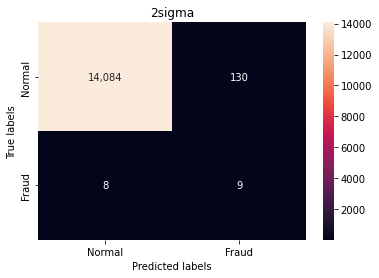

445/445 [==============================] - 1s 3ms/step
Precision 0.08
Recall 0.53
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     14214
           1       0.08      0.53      0.13        17

    accuracy                           0.99     14231
   macro avg       0.54      0.76      0.57     14231
weighted avg       1.00      0.99      0.99     14231



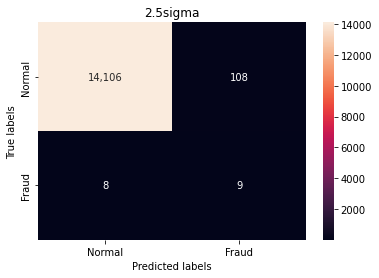

445/445 [==============================] - 1s 3ms/step
Precision 0.09
Recall 0.53
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     14214
           1       0.09      0.53      0.16        17

    accuracy                           0.99     14231
   macro avg       0.55      0.76      0.58     14231
weighted avg       1.00      0.99      1.00     14231



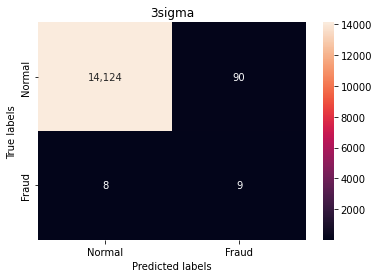

In [90]:
from sklearn.metrics import classification_report 

thresholds = sorted(thresholds.items(), key=lambda kv: kv[1])

def model_predict(threshold, mse):
     predictions = [(lambda er: 1 if er > threshold else 0)(er) for er in mse]
     return predictions

for sigma, threshold in thresholds:
    
    test_predictions = vae.predict(X_test)
    mse = np.mean(np.power(X_test - test_predictions, 2), axis=1)
    y_pred = model_predict(threshold, mse)

    print("Precision {:.2f}".format(precision_score(y_test, y_pred)))
    print("Recall {:.2f}".format(recall_score(y_test, y_pred)))

    cm = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred))

    ax = sns.heatmap(cm, annot=True, fmt=',')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.xaxis.set_ticklabels(['Normal', 'Fraud'])
    ax.yaxis.set_ticklabels(['Normal', 'Fraud'])
    ax.set(yticks=[0.5, 1.5], xticks=[0.5, 1.5])
    ax.set_title(sigma)
    plt.show()

# 5. 제출 파일 생성

In [ ]:
# col = train_x.columns.drop('Class')
col = train_x.columns

for i in col:
    sc=StandardScaler()
    test_df[i]=sc.fit_transform(test_df[i].values.reshape(-1,1))

In [ ]:
test_x = test_df.drop(columns=['ID'])
X_test = test_x.values

In [ ]:
predictions = autoencoder.predict(X_test) # model prediction
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})

threshold = 1.5
test_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]

In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/dacon/unsupervised_card/data/sample_submission.csv')
submit.head()

,ID,Class
0,AAAA0x1,1
1,AAAA0x2,1
2,AAAA0x5,1
3,AAAA0x7,1
4,AAAA0xc,1


In [ ]:
submit['Class'] = test_pred
submit.to_csv('/content/drive/MyDrive/dacon/unsupervised_card/submit_auto_encoder_220725.csv', index=False)

In [ ]:
submit['Class'].value_counts()

0    139731
1      2772
Name: Class, dtype: int64